## 2.Data Analysis

The second phase of the american-exp project is the Data analysis. On this stage the tasks to be accoplished is: download the data from the source, a description of the fields of the data, exploratory analysis and quality checkup. The objective of the phase is, with the main objective proposed on the first stage, identify, collect and analise what has to be made on the data to obtain a satisfactory result at the end.

### A) Download the data

The data is located at the kaggle website:https://www.kaggle.com/competitions/amex-default-prediction/data. Next, we will download the data into the data directory.

In [2]:
!kaggle competitions download -c amex-default-prediction

100%|█████████████████████████████████████▉| 20.5G/20.5G [14:29<00:00, 30.1MB/s]
100%|██████████████████████████████████████| 20.5G/20.5G [14:29<00:00, 25.3MB/s]


Unpacking the files.

In [3]:
!unzip ./amex-default-prediction.zip -d ../data/originalSet/

Archive:  ./amex-default-prediction.zip
  inflating: ../data/originalSet/sample_submission.csv  
  inflating: ../data/originalSet/test_data.csv  
  inflating: ../data/originalSet/train_data.csv  
  inflating: ../data/originalSet/train_labels.csv  


In [4]:
!rm ./amex-default-prediction.zip

Now we can proceed loading the data.

### B) Describe the data

The objective of this competition is to predict the probability that a custumer does not pay back their cred card balance amount in the future based on their monthly customer progile. The target binary variable is calculated by observing 18 months performance windows after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contais aggregated profile features for each costumer at each statement date. Features are anonymized and normalized and fall into the following general categories:

* D_*= Delinquency variables
* S_*= Spend variables
* P_*= Payment variables
* B_*= Balance variables
* R_*= Risk variables
    
with the following features being categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

the task is to predict, for each custumer_ID, the probability of a future payment default (target = 1).

The negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

the files are ordened as follows:

* train_data.csv - training data with multiple statement dates per custumer_ID
* train_labels.csv - target label for each custumer_ID
* test_data.csv - corresponding test data; your objective is to predict the target label for each customer_ID
* sample_submission.csv - a sample submission file in the correct format

The data is on a CSV format and subdivided into 4 files, but the sample_submission.csv is just a demonstration for the submission. In this section we will load the three remaning ".csv" and describe the data using the pandas library.

All the data has 50gb, we will need to change to dask dataframes to work with the data.

In [1]:
from dask.distributed import Client
import logging

client = Client(processes= False, n_workers=12, threads_per_worker=4, memory_limit=None, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.15.11:8787/status,
Dashboard: http://192.168.15.11:8787/status,Workers: 12
Total threads: 48,Total memory: 0 B
Status: running,Using processes: False
Comm: inproc://192.168.15.11/5030/1,Workers: 12
Dashboard: http://192.168.15.11:8787/status,Total threads: 48
Started: Just now,Total memory: 0 B
Comm: inproc://192.168.15.11/5030/4,Total threads: 4
Dashboard: http://192.168.15.11:39337/status,Memory: 0 B
Nanny: None,


In [98]:
import pandas as pd
pd.options.display.max_rows = 300
pd.options.display.max_columns = 300 

The client is initialized. Now we can read the csv. The dask will perform a lazy execution, where lazy mean that the dask will only load the data as necessary.

In [2]:
import dask.dataframe as dd
blocksize = '64MB'
#loading the data
x_test = dd.read_csv("../data/originalSet/test_data.csv", blocksize=blocksize)
x_train = dd.read_csv("../data/originalSet/train_data.csv", blocksize=blocksize)
y_train = dd.read_csv("../data/originalSet/train_labels.csv", blocksize=blocksize)

Now we can look at some samples.

In [3]:
x_train.head(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


One thing to notice is that besides the custumer_id is a unique identifier for the client, the client can have mutiple entries on the table. From this fact araise two more questions about the data. How many entries the client have? The number of entries is fixed for all clients? Ascertain the two questions is important because we need to standardize the dataset. In other words, we have to set a pattern for the data.

To answer the questions, we will take a look in some ids. 

In [4]:
samp_customer_1 = x_train[x_train['customer_ID'] =='0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a'].compute()

In [5]:
samp_customer_1

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0.001746,0.007863,1.005006,0.004220,0.110946,0.009857,0.009866,...,NaN,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0.002183,0.018859,1.008024,0.004509,0.103329,0.006603,0.000783,...,NaN,NaN,NaN,0.001336,0.004361,0.009387,NaN,0.007727,0.007661,0.002225
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0.003029,0.014324,1.000242,0.000263,0.108115,0.009527,0.007836,...,NaN,NaN,NaN,0.002397,0.008452,0.005553,NaN,0.001831,0.009616,0.007385
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0.009896,0.016888,1.003995,0.001789,0.102792,0.002519,0.009817,...,NaN,NaN,NaN,0.009742,0.003968,0.007945,NaN,0.008722,0.004369,0.000995
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0.001082,0.001930,1.007504,0.001772,0.100470,0.004626,0.006073,...,NaN,NaN,NaN,0.003611,0.009607,0.007266,NaN,0.008763,0.004753,0.009068


In [9]:
cust_counts = x_train.customer_ID.value_counts().compute()

In [10]:
samp_customer_2 = x_train[x_train['customer_ID'] == cust_counts.index[0]].compute()

In [11]:
samp_customer_2

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
86415,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-03-20,0.999057,0.208160,0.119478,1.009708,0.002409,-0.007296,0.005027,0.055891,...,NaN,NaN,NaN,0.004193,0.005777,0.007169,NaN,0.009378,0.007524,0.008007
86416,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-04-20,1.000050,0.240620,0.090471,0.239062,0.003122,-0.012420,0.005149,0.070238,...,NaN,NaN,NaN,0.004392,0.000838,0.005023,NaN,0.000946,0.005934,0.003523
86417,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-05-08,0.994954,0.504683,0.056324,0.276368,0.004393,-0.010588,0.005737,0.055695,...,NaN,NaN,NaN,0.009934,0.001795,0.004786,NaN,0.003711,0.001371,0.003976
86418,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-06-19,1.005768,0.206469,0.029999,0.620975,0.008176,0.033445,0.003778,0.038097,...,NaN,NaN,NaN,0.007099,0.004032,0.006044,NaN,0.009316,0.002273,0.002568
86419,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-07-20,0.965709,0.207843,0.042782,0.279508,0.001088,0.020815,0.006460,0.053584,...,NaN,NaN,NaN,0.009120,0.001992,0.004616,NaN,0.004960,0.009627,0.009150
86420,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-08-09,0.968892,0.563736,0.034385,0.435834,0.000037,0.028395,0.001631,0.044833,...,NaN,NaN,NaN,0.004772,0.008386,0.002413,NaN,0.005524,0.008519,0.009013
86421,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-09-20,0.973780,0.239892,0.046246,0.732382,0.007093,0.081627,0.003543,0.030779,...,NaN,NaN,NaN,0.003733,0.009658,0.009789,NaN,0.003017,0.004599,0.009291
86422,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-10-20,0.979511,0.002230,0.022695,0.557029,0.008897,0.091565,0.000880,0.045471,...,NaN,NaN,NaN,0.003243,0.008768,0.005807,NaN,0.001374,0.003811,0.008520
86423,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979332,0.416013,0.020818,0.828199,0.003487,0.090743,0.005340,0.025139,...,NaN,NaN,NaN,0.006838,0.003680,0.000457,NaN,0.000905,0.001498,0.002774
86424,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,0.296536,0.007209,0.812610,0.005904,0.079886,0.002243,0.023691,...,NaN,NaN,NaN,0.003310,0.007097,0.007857,NaN,0.002777,0.008225,0.008856


The date isn't of the same day but the space between the dates follows a pattern of 1 month. For the project, measuring the data every day does'nt seem necessary, respecting a month interval is reasonable. Let's look at the histogram distribution of the same customer ID occurrences, but first, before proccedding, let's refresh how many samples we have at hand.

In [12]:
print(f'Dimensions of the datasets:\nx_train: ({x_train.shape[0].compute()}x{x_train.shape[1]})'+
      f'| y_train: {y_train.shape[0].compute()}x{y_train.shape[1]}\nx_test: {x_test.shape[0].compute()}x{x_test.shape[1]}')

Dimensions of the datasets:
x_train: (5531451x190)| y_train: 458913x2
x_test: 11363762x190


5,531,451 rows and 190 columns for the x_train. 11,363,762 rows and 190 columns for the x_test.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Sorting
cust_counts = cust_counts.value_counts()
sort_index = cust_counts.index.sort_values()

Brute numbers of the recorrencies in the customer ID from the train set. 

In [14]:
cust_counts

13    386034
12     10623
10      6721
9       6411
8       6110
2       6098
11      5961
3       5778
6       5515
7       5198
1       5120
4       4673
5       4671
Name: customer_ID, dtype: int64

Notice that we have to multiply the count of rows per customer ID by the number of ocourrences of customer ID to obtain the numbers present in the shape. e.g. 13*386034+12*10623+.... We can already see that the counts for the 13 ocourrences is much bigger than the rest. It's important for making the decision about the procedure to resolve this proble, to know how much of the dataset represents each ocurrence.

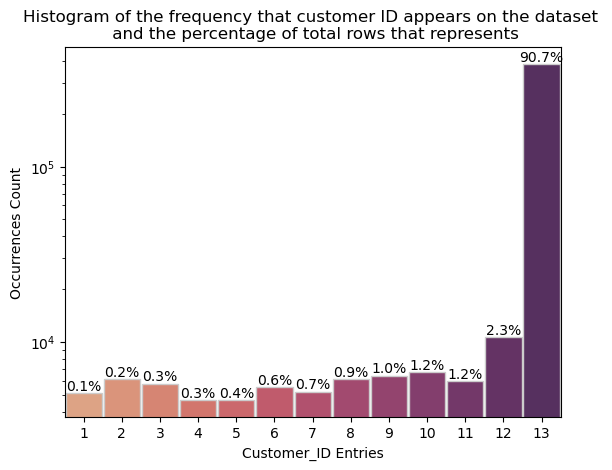

In [15]:
#barplot
bar = sns.barplot( x=sort_index, y=cust_counts[sort_index], log=True, palette="flare", edgecolor=".8", width=0.95)
#setting grid
#setting titles
bar.set(ylabel='Occurrences Count', xlabel='Customer_ID Entries',
        title='Histogram of the frequency that customer ID appears on the dataset \n and the percentage of total rows that represents')

#adding a percentage on the top of the bars, representing the percentage of rows of the data set
#getting bars to customize
rects = bar.containers[0].get_children()
#total number of rows
total_rows = 5531451
for rect, idx in zip(rects, sort_index):
    height = rect.get_height()
    percent = (idx*height)/total_rows
    plt.text(rect.get_x()+rect.get_width()/2.0, height, f'{percent:.1%}', ha='center', va='bottom')
    

Notice that 10 and 11 corresponds to the same participation on the dataset, this is because of the multiplication presented above.

We can see the 13 entries per custumer_ID is the dominant on the dataset. If we decide to eliminate all occurrences which doesn't have 13 entries, we still have 90.7% of the dataset to make the predictions. Moreover, we can eliminate one entrie of each customer ID that has 13 entries, therefore, we would have more 2.3% of the data to train the model. Next, we will make the same procedure for the x_test dataset. 

In [16]:
x_test.head(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,0.002347,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008281,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009021,NaN,0.003695,0.003753,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002114,0.004656,NaN,0.003155,0.002156,0.006482
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614911,0.009065,0.021672,0.816549,0.009722,0.188947,0.004123,0.015325,...,NaN,NaN,NaN,0.004743,0.006392,0.002890,NaN,0.006044,0.005206,0.007855
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591673,0.238794,0.015923,0.810456,0.002026,0.180035,0.000731,0.011281,...,NaN,NaN,NaN,0.008133,0.004329,0.008384,NaN,0.001008,0.007421,0.009471


In [17]:
cust_counts = x_test.customer_ID.value_counts().compute()

In [18]:
#Sorting
cust_counts = cust_counts.value_counts()
sort_index = cust_counts.index.sort_values()

Brute numbers of the recorrencies in the customer ID from the test set. 

In [16]:
cust_counts

13    811329
12     16327
9      10552
11      9943
8       9775
7       9653
10      9638
6       8833
5       8419
4       8348
2       8174
3       7803
1       5827
Name: customer_ID, dtype: int64

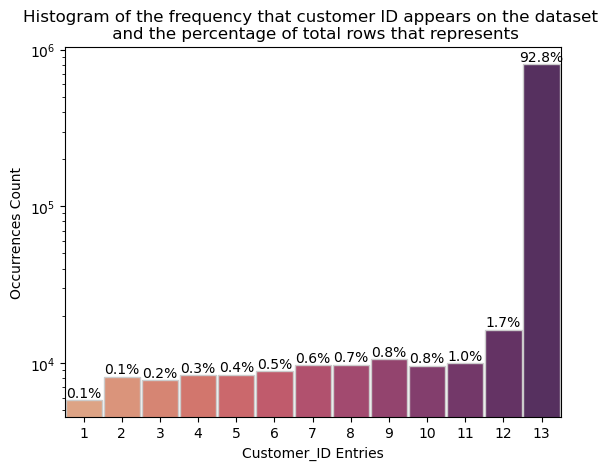

In [20]:
#barplot
bar = sns.barplot( x=sort_index, y=cust_counts[sort_index], log=True, palette="flare", edgecolor=".8", width=0.95)
#setting grid
#setting titles
bar.set(ylabel='Occurrences Count', xlabel='Customer_ID Entries',
        title='Histogram of the frequency that customer ID appears on the dataset \n and the percentage of total rows that represents')

#adding a percentage on the top of the bars, representing the percentage of rows of the data set
#getting bars to customize
rects = bar.containers[0].get_children()
#total number of rows
total_rows = 11363762
for rect, idx in zip(rects, sort_index):
    height = rect.get_height()
    percent = (idx*height)/total_rows
    plt.text(rect.get_x()+rect.get_width()/2.0, height, f'{percent:.1%}', ha='center', va='bottom')
    

In a real scenario we would have a option to restrict the data set based on the number of entries. The rules of the competition doesn't allow this, so we will have to build a model that performs well on this vast range of entries. If the customer has 13 entries of data, or if the customer has just 1 the model has to perform well.

The problem we are trying to solve is a classification problem, default or not default. On the page of the competition, they told us that the data was skeewed and oversampling was aplied to correct the issue. Let's look at the distribution on the predict variable.

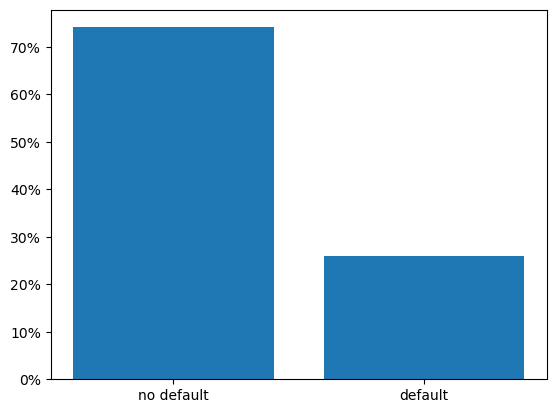

In [128]:
import matplotlib.ticker as mtick
#plotting the percentage of target
target_name = ['no default', 'default']
fig, ax = plt.subplots()
ax.bar(target_name ,(y_target_count/sum(y_target_count))*100)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


We can see that the data is skeewed to no default. No-default corresponds to ~75% of the data available, and the rest is default. 

The describe method will give insights about the dataset.

In [99]:
x_train.describe().compute()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5.485466e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.531451e+06,4.510907e+06,5.529435e+06,5.529435e+06,791314.000000,3.873055e+06,5.257132e+06,5.531451e+06,5.529434e+06,5.531451e+06,5.531451e+06,4.319752e+06,5.531451e+06,4.812726e+06,5.455340e+05,5.531218e+06,5.531451e+06,5.509183e+06,2.389049e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.501888e+06,5.229959e+06,5.531451e+06,1.446866e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.531451e+06,4.510907e+06,5.531451e+06,5.531451e+06,5.346648e+06,2.540508e+06,5.481932e+06,5.531451e+06,5.531451e+06,2.597808e+06,5.531451e+06,5.424726e+06,5.531451e+06,4.933399e+06,5.524528e+06,5.531451e+06,4.773290e+06,5.531451e+06,5.529435e+06,2.393853e+06,5.531451e+06,5.529435e+06,623354.000000,5.529435e+06,5.314948e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.336978e+06,5.529435e+06,5.436534e+06,5.531451e+06,5.507743e+06,5.531451e+06,5.531451e+06,55856.000000,5.531451e+06,5.509678e+06,5.531451e+06,6.224970e+05,5.531451e+06,5.531450e+06,3.017539e+06,5.524528e+06,5.529435e+06,5.257132e+06,5.455512e+06,5.531451e+06,3.125330e+05,5.531451e+06,5.509678e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.505764e+06,1.472837e+06,5.531451e+06,5.531395e+06,5.531451e+06,5.531451e+06,5.336978e+06,5.531450e+06,5.531451e+06,5.501888e+06,5.531451e+06,3.814160e+05,5.529435e+06,5.531451e+06,5.531451e+06,3865.0,5.531451e+06,5.531451e+06,6004.000000,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531376e+06,5.531451e+06,5.529435e+06,5.501888e+06,5.531451e+06,5.531451e+06,5.374235e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.512427e+06,5.531006e+06,5.512858e+06,5.518604e+06,5.530817e+06,5.490796e+06,5.429903e+06,5.429903e+06,2.510020e+06,5.413490e+05,5.429903e+06,5.531451e+06,5.531395e+06,6.093050e+05,5.402748e+06,5.529435e+06,2.893800e+04,5.529854e+06,31334.000000,31334.000000,33632.000000,5.528801e+06,5.531398e+06,4.130516e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.354735e+06,5.414635e+06,5.531451e+06,5.429903e+06,5.429903e+06,5.530761e+06,71478.000000,5.429903e+06,5.429903e+06,542577.000000,5.488735e+06,5.531451e+06,194699.000000,1.946990e+05,1.946990e+05,1.946990e+05,1.946990e+05,5.429903e+06,5.490819e+06,5.429903e+06,944408.000000,5.429903e+06,5.490724e+06,5.429903e+06
mean,6.563340e-01,1.531172e-01,1.240100e-01,6.214887e-01,7.880270e-02,2.258455e-01,5.978469e-02,1.325389e-01,0.184974,1.546841e-01,1.184431e-01,1.725543e-01,2.521867e-01,8.311185e-02,4.751791e-02,4.754784e-01,4.071093e-01,3.816245e-01,1.919254e-01,1.521174e-01,1.860836e-01,4.505812e-01,1.744347e-01,1.450790e-01,1.895237e-01,1.208287e-01,1.800504e-01,6.012886e-01,2.316003e-01,7.618341e-02,8.810534e-02,1.109685e-01,2.441923e-01,9.846392e-01,3.120413e-02,2.231380e-01,9.369956e-02,3.275998e-01,2.980905e-01,2.037094e-01,1.007155e-01,3.459403e-02,2.155312e-01,7.441472e-02,1.011546e-01,3.624224e-01,3.761550e-01,4.296291e-01,5.280

From the first row, in both datasets, we can see that we have a lot of missing values in a lot of features. One possible solution for standadize all features maybe is take the last valid result for the feature. The mean of the last and the next valid result maybe is a better aproximation. We aready saw that we have less than 1% of the data that has only one costumer ID, for the majority of the cases the solution is acceptable. Another problem is the range of the features, a scale and normalization is required.

In [103]:
x_train.info(verbose = True)

<class 'dask.dataframe.core.DataFrame'>
Int64Index: 5531451 entries, 0 to 21606
Data columns (total 190 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_ID  5531451 non-null      object
 1   S_2          5531451 non-null      datetime64[ns]
 2   P_2          5485466 non-null      float64
 3   D_39         5531451 non-null      float64
 4   B_1          5531451 non-null      float64
 5   B_2          5529435 non-null      float64
 6   R_1          5531451 non-null      float64
 7   S_3          4510907 non-null      float64
 8   D_41         5529435 non-null      float64
 9   B_3          5529435 non-null      float64
10   D_42         791314 non-null      float64
11   D_43         3873055 non-null      float64
12   D_44         5257132 non-null      float64
13   B_4          5531451 non-null      float64
14   D_45         5529434 non-null      float64
15   B_5          5531451 non-null      float64
16   R_2          5531451 non-nul

From the method info we can observe a large number of missing values. They will need some imputation techinique. The majority of values is float64 type. There is 3 columns of type object, let's inspect.

In [105]:
x_train['D_63'].unique().compute()

0    CR
1    CO
2    CL
3    XZ
4    XM
5    XL
Name: D_63, dtype: object

In [107]:
x_train['D_64'].unique().compute()

0      O
1      R
2    NaN
3      U
4     -1
Name: D_64, dtype: object

The object is a string, this corresponds to categorical features and will need some encoding procedure in the next stage. The other one is the customer_ID, we already now what it is. 

The 

In [38]:
x_train["S_2"] = x_train["S_2"].astype("datetime64[ns]")
date_hist = x_train[['S_2','customer_ID']].groupby(x_train["S_2"]).count().compute()
date_hist['S_2'] = date_hist.index

In [39]:
date_hist

,S_2,customer_ID
S_2,,
2017-03-01,2017-03-01,10381
2017-03-02,2017-03-02,8952
2017-03-03,2017-03-03,13635
2017-03-04,2017-03-04,14463
2017-03-05,2017-03-05,7879
...,...,...
2018-03-27,2018-03-27,15457
2018-03-28,2018-03-28,17263
2018-03-29,2018-03-29,14414


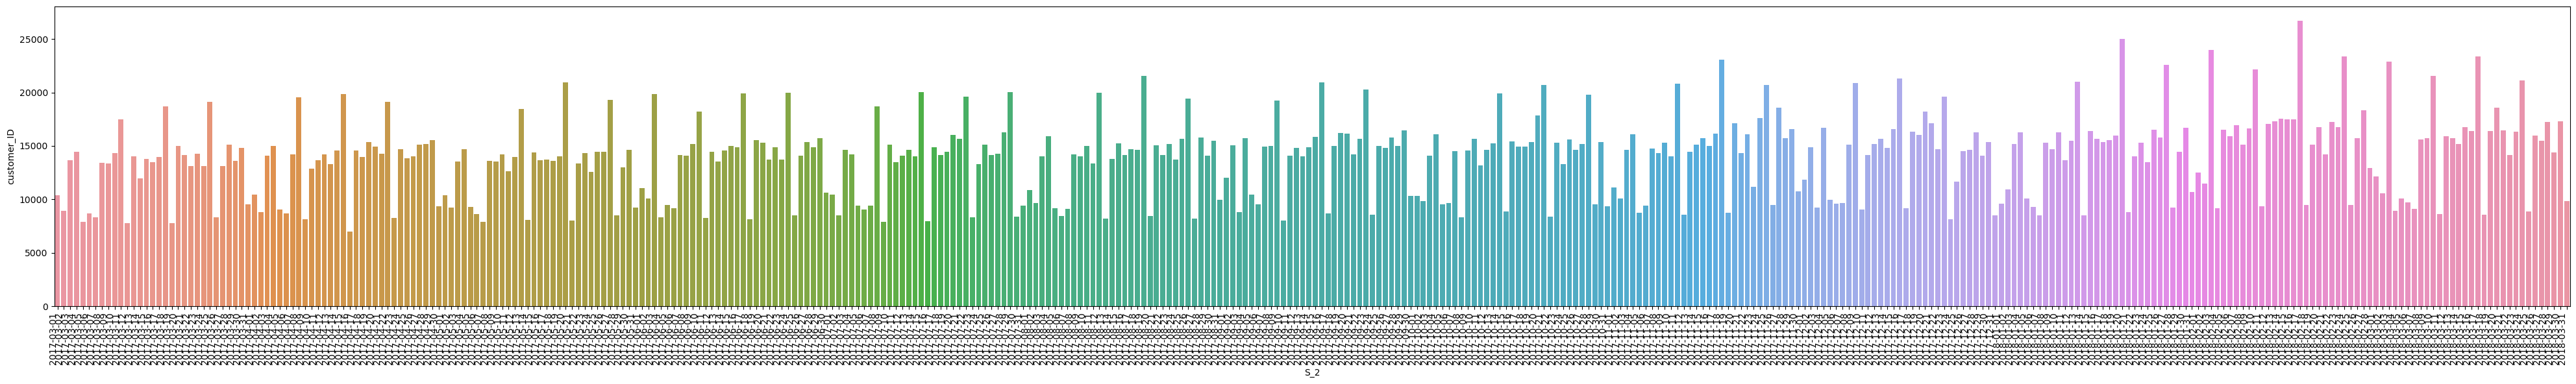

In [40]:
fig, ax = plt.subplots(figsize = (50,6))
fig = sns.barplot(x = 'S_2', y = 'customer_ID', data=date_hist ,estimator='mean', ci=None, ax=ax)

x_dates = date_hist['S_2'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');

In [41]:
dh = date_hist.groupby(pd.Grouper(key='S_2', axis=0, freq='M')).sum()
dh['S_2'] = dh.index
dh

,customer_ID,S_2
S_2,,
2017-03-31,395630,2017-03-31
2017-04-30,401556,2017-04-30
2017-05-31,400306,2017-05-31
2017-06-30,410384,2017-06-30
2017-07-31,415602,2017-07-31
2017-08-31,421099,2017-08-31
2017-09-30,425455,2017-09-30
2017-10-31,430292,2017-10-31
2017-11-30,434268,2017-11-30


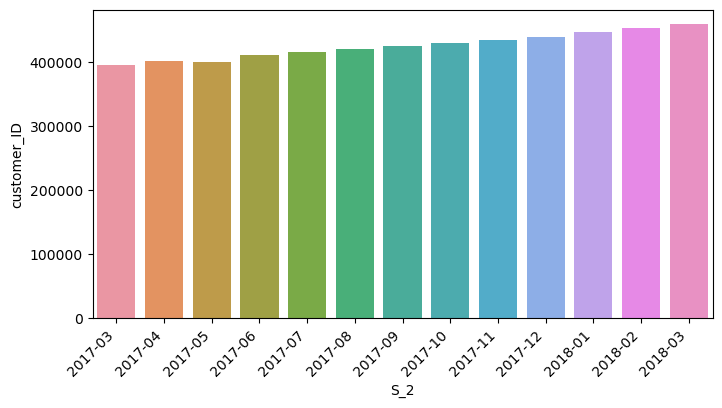

In [42]:
fig, ax = plt.subplots(figsize = (8,4))
fig = sns.barplot(x = 'S_2', y = 'customer_ID', data=dh ,estimator='mean', ci=None, ax=ax)

x_dates = dh['S_2'].dt.strftime('%Y-%m').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right');

It's a one year period. 2017-03 to 2018-03. The Last month is the month with more entries, maybe it's because new clients enter in the middle.

Making the same plot to the test set.

In [43]:
#transforming in date tipy to perform date operations
x_test["S_2"] = x_test["S_2"].astype("datetime64[ns]")
#creating a pandas dataframe to hold the counts
date_hist = x_test[['S_2','customer_ID']].groupby("S_2").count().compute()

In [44]:
date_hist['S_2'] = date_hist.index

In [45]:
dh = date_hist.groupby(pd.Grouper(key='S_2', axis=0, freq='M')).sum()
dh['S_2'] = dh.index
dh

,customer_ID,S_2
S_2,,
2018-04-30,410283,2018-04-30
2018-05-31,415458,2018-05-31
2018-06-30,420206,2018-06-30
2018-07-31,424757,2018-07-31
2018-08-31,430648,2018-08-31
2018-09-30,436207,2018-09-30
2018-10-31,851138,2018-10-31
2018-11-30,860669,2018-11-30
2018-12-31,869114,2018-12-31


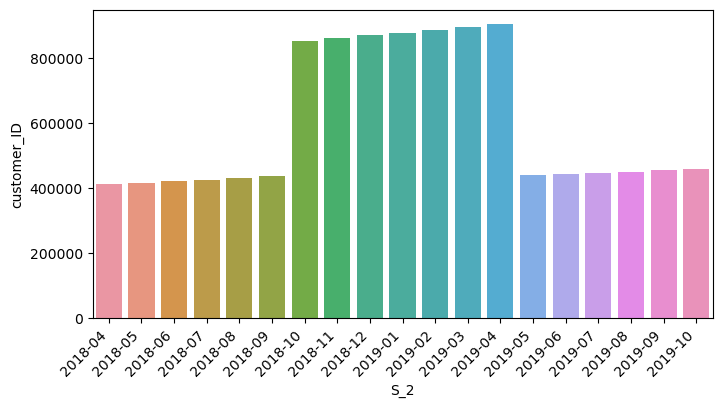

In [46]:
fig, ax = plt.subplots(figsize = (8,4))
fig = sns.barplot(x = 'S_2', y = 'customer_ID', data=dh ,estimator='mean', ci=None, ax=ax)

x_dates = dh['S_2'].dt.strftime('%Y-%m').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right');

The test data set has a peculiar distribution by months. the end of 2018 and the begining of 2019 has more data. Moreover, the data begin at the end point of the train dataset. This is a typical in a time series setup. 

From now on, we will analyse just a sample from the total. The dataset is too big.

To sample we have to consider the total timeseries. So we will sample the customer, than we will search for the rest of the customer entries and add on the sampled data set.
We will also need to sort the dataset.

In [3]:
x_train["S_2"] = x_train["S_2"].astype("datetime64[ns]")
x_train_samp = x_train['customer_ID'].sample(frac=(1/200)).compute()

In [4]:
unique_samp = x_train_samp.unique()
len(unique_samp)

26898

In [6]:
unique_samp

array(['0009a85feed29c69e41a1dfa6375ba7010870adbe7550e4ce2f1d4c564db1691',
       '00848ddcbe1d00d115e77152807b97b6ade9abc5650757cec5ebefe38d02c591',
       '002abf4ab6b6b6b1f05369304c0dc8ec61ba078abbccdd015d7d7136dfda6ca6',
       ...,
       'ff4acc3851413b0411c8b1255eddc593a43e11269753487bce0c0e268f81d61f',
       'ff37dbdc4446ca1895d0342356a1a255e57da950f6b29539e2088f4e04773f42',
       'ffd3e61ae245aa5b90eef654cb4027d3365289a056fbbba9497d8ec6d3f45299'],
      dtype=object)

In [6]:
x_train_samp = x_train.loc[x_train['customer_ID'].isin(unique_samp)].compute()

In [7]:
len(x_train_samp)

338963

In [8]:
y_train_samp = y_train.loc[y_train['customer_ID'].isin(unique_samp)].compute()

In [9]:
 x_train_samp.columns[2:4]

Index(['P_2', 'D_39'], dtype='object')

Sorting to optimize the searchs

In [10]:
x_train_samp = x_train_samp.sort_values(by=['customer_ID', 'S_2'])

In [11]:
y_train_samp = y_train_samp.sort_values(by=['customer_ID'])

In [13]:
x_train_samp = x_train_samp.reset_index(drop=True)

In [14]:
y_train_samp = y_train_samp.reset_index(drop=True)

In [15]:
counts_customer = x_train_samp.value_counts(subset='customer_ID', sort=False)

With the values counted and the sorted elements, we can now procced with the algorthim more eficiently. We have to build this beacuse the operation of search .loc is to expensive, is more eficient to just acess the elements by index.

In [16]:
counts_customer.values

array([13, 13, 13, ..., 13, 13,  7])

In [21]:
columns_plot[120:]


Index(['R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22',
       'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105',
       'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'B_38', 'D_108',
       'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113',
       'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121',
       'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129',
       'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134',
       'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142',
       'D_143', 'D_144', 'D_145'],
      dtype='object')

We capture the rest of the timestamps for the customer samples. The total of samples correspond rougly to 0,5% of samples. The total has a little more than 5m, so 338191 is more than 0,5%. Besided we are working with 0,5% of samples, note that the data set is already pretty big so let's procced with the analyses.

In [22]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from IPython.display import clear_output
#select columns to plot
columns_plot = x_train_samp.columns[2:]
#list for the final result
rst_agg = []
idx_start = 0
idx_end = 0
#for each unique customer_ID on the sample
for idx, customer_space in enumerate(counts_customer.values):
    print(f'{idx}')
    #selecting the customer space
    idx_end += customer_space 
    #select the customer on the train dataset
    samp = x_train_samp[idx_start:idx_end]
    #get the target
    y_samp = y_train_samp.iloc[idx]
    #get the dates
    s_2 = samp['S_2']
    
    columns_agg = []
    #for each column(feature) plot histogram
    for column in columns_plot:
        feat = samp[column]
        columns_agg.append((s_2, feat, y_samp))
    
    rst_agg.append(columns_agg)
    idx_start = idx_end 
    clear_output(wait=True)


26897


In [23]:
#for each column, build a plot
for idx, column in enumerate(columns_plot):
    fig, ax = plt.subplots(figsize = (10,6))
    try:
        #for each plot, pass all the customers values
        for rst_a in rst_agg:
            #plot the feature
            if rst_a[idx][2]['target'] == 0:
                no_default = ax.plot(rst_a[idx][0], rst_a[idx][1], color='C0', alpha=0.01)
            if rst_a[idx][2]['target'] == 1:
                default = ax.plot(rst_a[idx][0], rst_a[idx][1], color='red', alpha=0.01)

        #setting the plot
        ax.set_title(f'Histogram feature {column}')
        cz_patch = mpatches.Patch(color='C0', label='no default')
        red_patch = mpatches.Patch(color='red', label='default')
        ax.legend(handles = [cz_patch, red_patch],loc = 'lower right')
        plt.savefig(f'./histograms/hist-{column}.png')
        plt.close()
    except:
        print(f'feature {column} failed!' )

just the feature 'D_64' fails but may have other features that the plot is not so significative. the D_64 is a categorical feature with strings, needs to pass procedures on the next phase to correct the categorical feature.

We will plot the feature P_2 as an example.

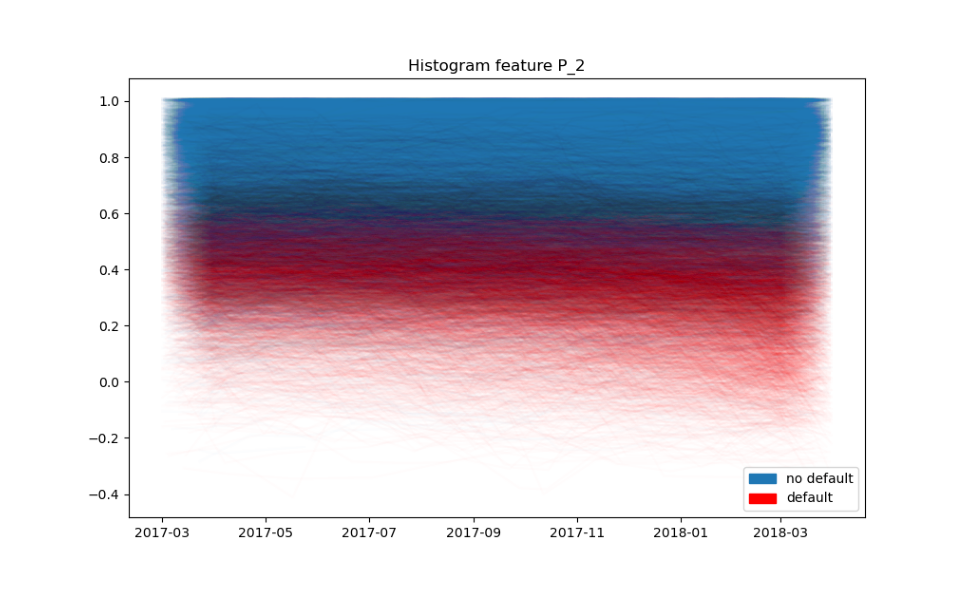

In [59]:
from PIL import Image
%matplotlib inline
image = Image.open('./histograms/hist-P_2.png')
#image.resize((10,6))
plt.figure(figsize=(10,6))
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()


The graph above, plot an adaptation of histogram for time series for the variable P_2. The rest of the graphs can be found on the histograms foulder. This is great result for the analysis, we can observe that we can clearly separete the defaults. We can also note a region where there is a overlapping between the red(default) and the blue(no default)

Next some more examples.

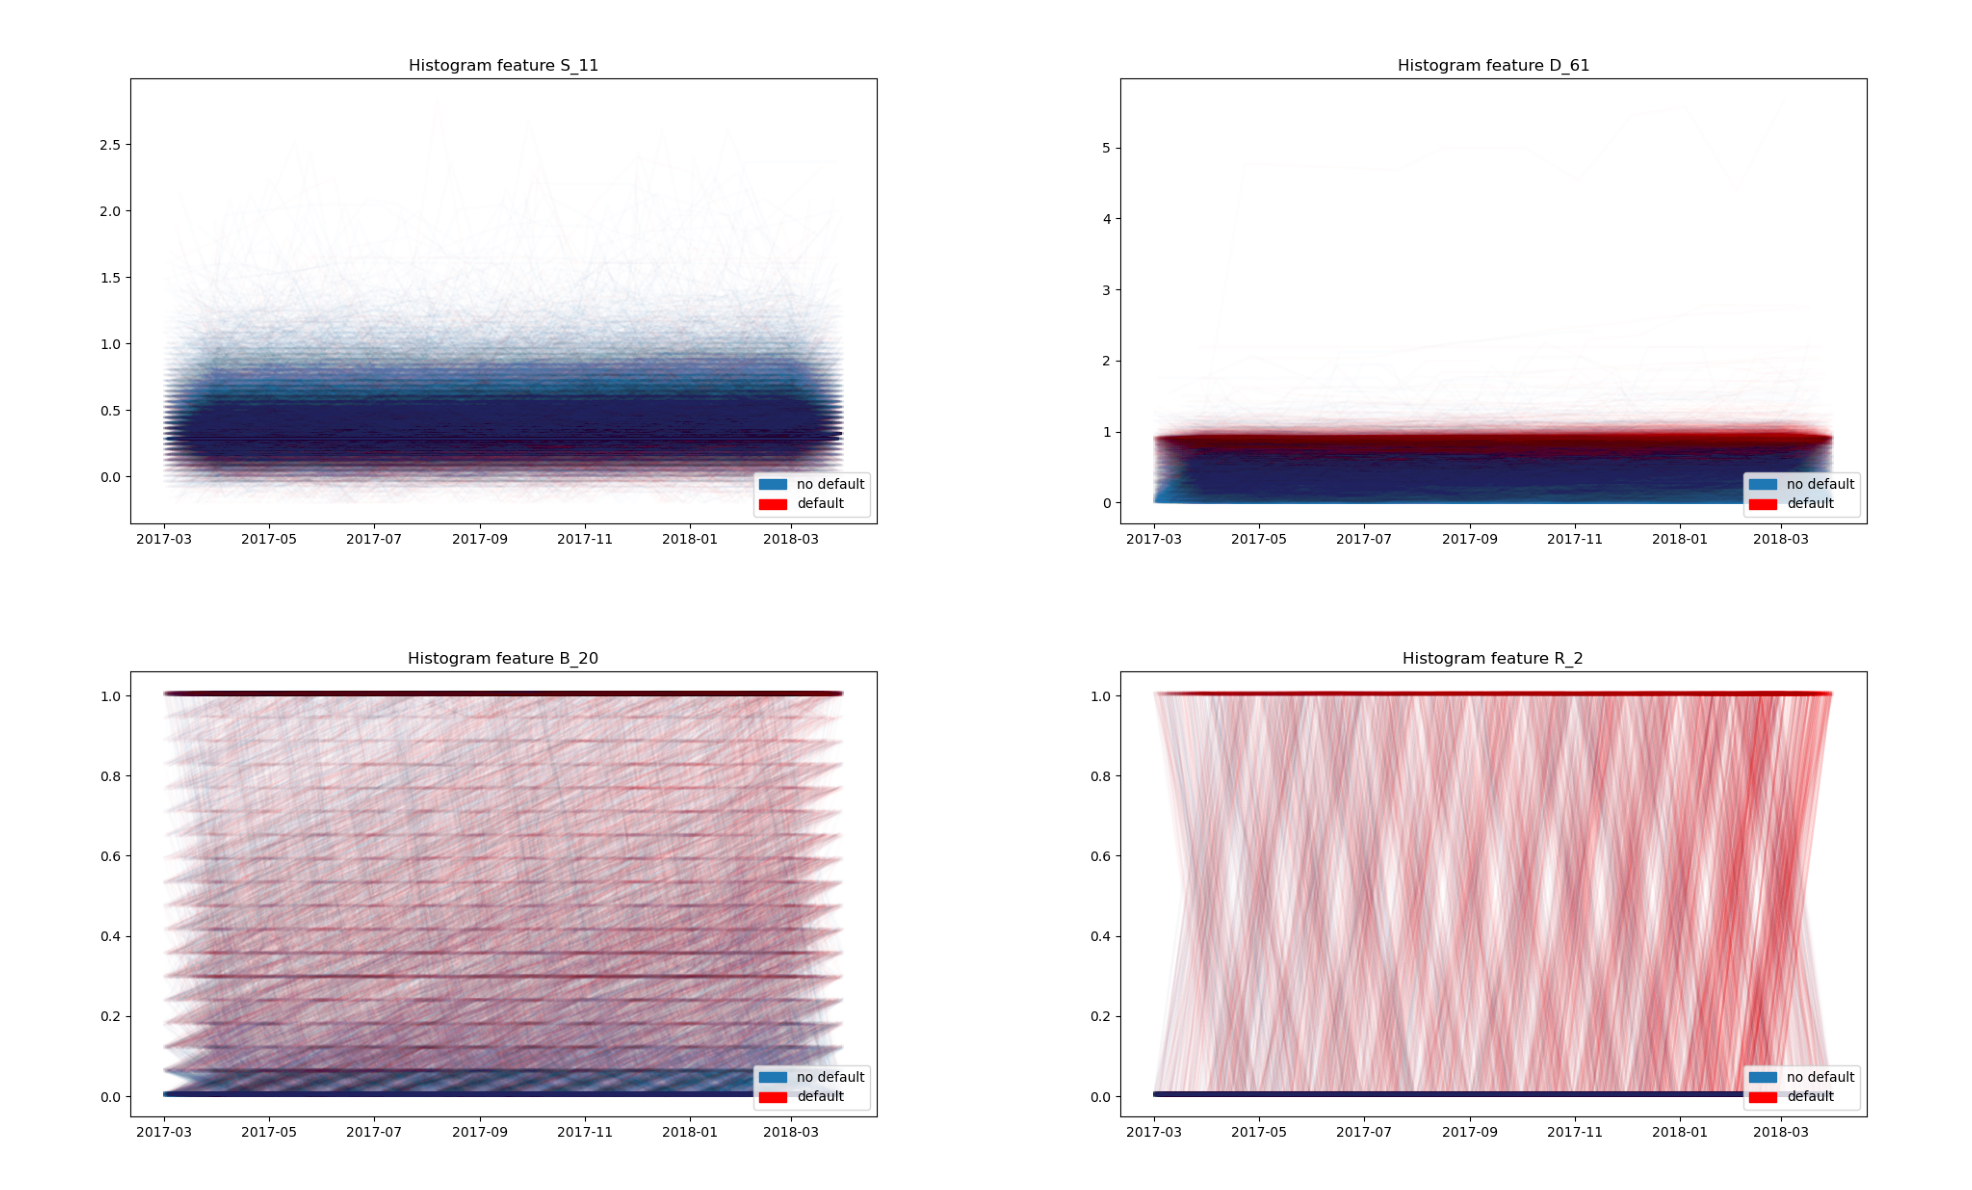

In [94]:
images = []
images.append(Image.open('./histograms/hist-S_11.png'))
images.append(Image.open('./histograms/hist-D_61.png'))
images.append(Image.open('./histograms/hist-B_20.png'))
images.append(Image.open('./histograms/hist-R_2.png'))

fig, axs = plt.subplots(2,2, figsize=(20,12))
iter_images = iter(images)
for ax in axs:
    for ax_ in ax:
        ax_.imshow(next(iter_images))
        ax_.axis('off')
plt.tight_layout()

From the examples ploted, we can observe some tendencies in some areas. Like the first example, the D_61 has two distict regions but much more aglomerated. The R_2 demonstante that a value of 1 has a tendency for default. The features B_20 and S_11 doesn't have a strong predominant but we can not exclude those features, because they  maybe help us determine some samples. 

## C) Conclusion 

In overall, the features has great potential to solve the problem of predicting the defaults as the plots of the features vs date suggest, however the data will need heavy preprocessing. Summarizing the procedures developed on the data analysis stage:

1. Distribution of the recorded data for each custumer_ID: We looked at the plots of the distribution of counts of custumer_IDs. In other words, we count the ocurrence of custumer_IDs. We noted that the majority(~90%) of the data has 13 entries in distinct dates. We also observed that the counts has a range of 1 to 13. This is a problem that have to be corrected at the preprocessing stage. One possible solution is use only one monthy to predict the defaul. Another solution is to add a pad of dates and threat the missing values just like the other samples. 
2. Distribution of the dataset for each month: We looked at the distribution of the data for each month. This plot showed to us a strange pattern on the test set. No further improvement can be made besides the described above, but is a caracteristic that we have to pay attention on the modeling stage.
3. Missing data: We observed that the data has a great number of missing values. Imputation methods has to be used to solve the problem. One imputation strategy is use the precedding and next feature value in time, calculating a mean to fill the gap. This solution doesn't works for all missing data, the rest of the data maybe beneficial in using the last valid feature value. 
4. Data type: We oberve that some categorical features is on a string format and need to be encoded. More over the categorical features also have to be encoded. The one hot encoding maybe used. 
5. Distribution of the defaults for each feature: We plotted the graphs for the features and put in evidence the target class(default or not). The features showed to us patterns patterns with great potential on the solution of the default problem. 
6. Transform 'S_2': transform date in type datetime64[ns] and truncate by month.
